In [439]:
from itertools import product
import numpy as np
from scipy import stats
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt

WDBC_PATH = "Datasets/WDBC.dat"

INFO_FEATURES  = ["id", "diagnosis"]
FEATURES_NAMES = ["radius", "texture", "perimeter", "area",
                  "smoothness", "compactness", "concavity",
                  "concave_points", "symmetry", "fractal_dimension"]
FEATURE_TYPES  = ["mean", "se", "worst"]  # mean, standard error, max or 'worst'
FEATURES       = ["_".join(p) for p in product(FEATURE_TYPES, FEATURES_NAMES)]

In [32]:
def load_wdbc_data(wdbc_path=WDBC_PATH):
    """ Load data and add headers. """
 
    names = INFO_FEATURES + FEATURES
    
    df = pd.read_csv(wdbc_path, header=0, names=names)
    df['id'] = df['id'].astype(str)  # treat ID as a string, to avoid multiple issues
    
    return df

wdbc = load_wdbc_data()

## Perimeter statistics

Estimating the mean, median, and standard deviation of cells' perimeter is a deceptively tricky task to do correctly. The cause of our difficulties lies in the fact that the reported data for each cell is aggregated as a mean +/- standard error from multiple measurements per cell. 

The correct way to deal with such problems is via hierarchical Bayesian models. Here, however, we do not have access to the underlying measurements but only two summary statistics.

In [474]:
P = wdbc["mean_perimeter"]
S = wdbc["se_perimeter"]

Let's look at the perimeter data means and standard errors.

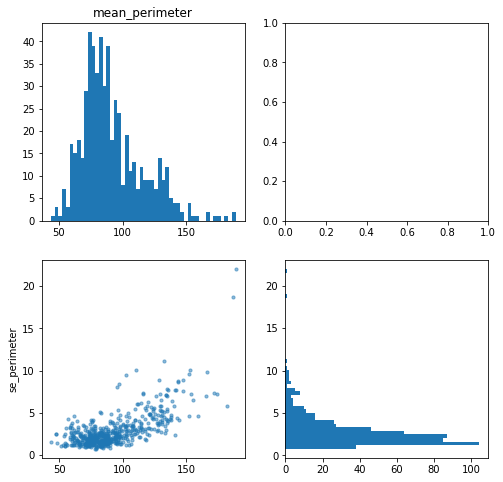

In [506]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
ax[0][0].hist(P, bins=50)
ax[0][0].set_title("mean_perimeter")

ax[1][0].scatter(P, S, s=10, alpha=0.5)
ax[1][1].hist(S, bins=50, orientation="horizontal")
_ = ax[1][0].set_ylabel("se_perimeter")

We see that measurements errors can be quite large, particularly for larger cells. 

The figure below shows what the underlying data *might* look like if we assume measurements of cell perimeter were Normally distributed around each cell's reported mean and with standard deviation equal to the measurement standard error.

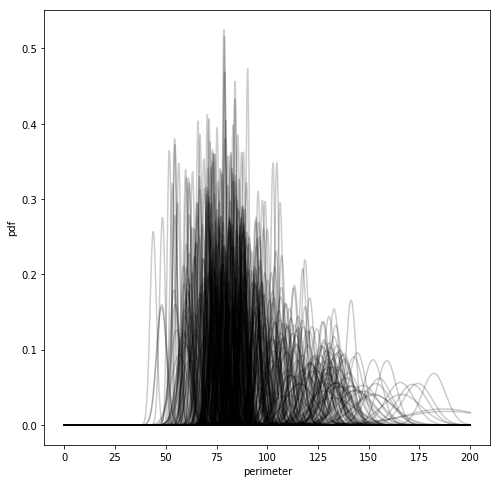

In [510]:
p_range = np.linspace(0, 200, 1000)
fig, ax = plt.subplots(1, 1, figsize=(8,8))

for i in range(P.shape[0]):
    ax.plot(p_range, stats.norm.pdf(p_range, loc=P.values[i], scale=S.values[i]), color='k', alpha=0.2)
    
ax.set_xlabel("perimeter")
_ = ax.set_ylabel("pdf")

We can see from the above plot why not accounting for measurement error might not give us very good estimates. In particular, the wide distributions from the higher end of the range might affect our estimate of the standard deviation.

A fully Bayesian hierarchical model treatment with missing data is a challenging problem, to say the least. I will instead opt for a simpler Monte Carlo approach for estimating perimeter statistics (and leave the Bayesian goodness for the next section).

We will simulate per-cell measurements under the above Normality assumption. We will then estimate population statistics from these samples.

In [526]:
def simulate_measurements(P, S, n_cell_measurements):
    """
    Generate n_cell_measurements for each cell.
    
    Assumes normal distribution of perimeter measurements with means P
    and standard errors S.
    """
    
    n_cells = P.shape[0]

    p_samples = np.zeros(n_cell_measurements * n_cells)

    for i in range(n_cells):
        p_samples[i*n_cell_measurements:(i+1)*n_cell_measurements] = stats.norm.rvs(loc=P[i], scale=S[i], size=n_cell_measurements)
        
    return p_samples

We will repeat this procedure many times to calculate confidence intervals for each statistic.

In [590]:
p_mean = []
p_median = []
p_std = []

n_bootstraps = 10000
n_cell_measurements = 100

for i in range(n_bootstraps):
    p_samples = simulate_measurements(P, S, n_cell_measurements)
    p_mean.append(np.mean(p_samples))
    p_median.append(np.median(p_samples))
    p_std.append(np.std(p_samples))

Plot the bootstrap distributions, showing the 95% high density interval. It's fine to use quantiles here, rather than some complicated method to calculate the high-density region. By the central limit theorem, these distributions should be Normal.

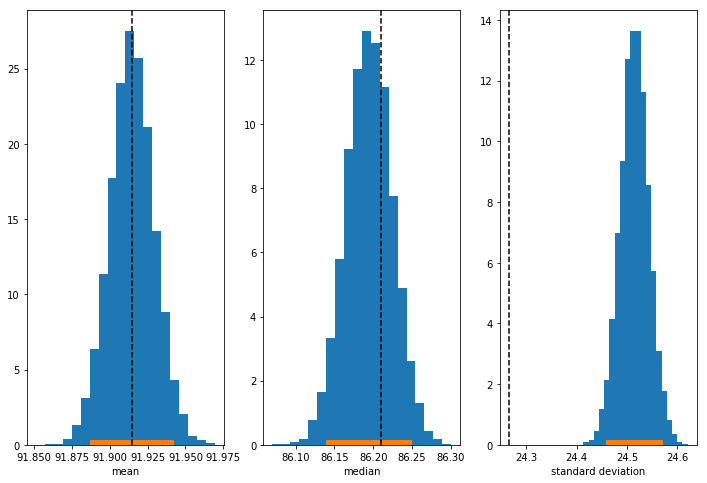

In [597]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].hist(p_mean, bins=20, density=True)
ax[0].plot(np.percentile(p_mean, [5, 95]), [0, 0], linewidth=10)
ax[0].axvline(np.mean(P), color='k', linestyle='--')
ax[0].set_xlabel("mean")

ax[1].hist(p_median, bins=20, density=True)
ax[1].plot(np.percentile(p_median, [5, 95]), [0, 0], linewidth=10)
ax[1].axvline(np.median(P), color='k', linestyle='--')
ax[1].set_xlabel("median")

ax[2].hist(p_std, bins=20, density=True)
ax[2].plot(np.percentile(p_std, [5, 95]), [0, 0], linewidth=10)
ax[2].axvline(np.std(P), color='k', linestyle='--')
_ = ax[2].set_xlabel("standard deviation")

Blue histogram is the simulated data. Orange line is the 95% confidence interval. Broken black line is the naive mean/median/std estimate from the sample's aggregate quantities without accounting for underlying measurements.

The 95% confidence interval for the perimeter mean (orange interval in above figure) is:

In [593]:
print(np.percentile(p_mean, [5, 95]))

[91.89046024 91.93887344]


The 95% CI for the perimeter median:

In [594]:
print(np.percentile(p_median, [5, 95]))

[86.14529445 86.2435364 ]


The 95% CI for the perimeter standard deviation:

In [595]:
print(np.percentile(p_std, [5, 95]))

[24.4674935  24.56166881]


There is no disagreement between our Monte Carlo method and the sample mean. The sample estimate for the median also falls in our 95% CI. However, our method and the sample estimate disagree with regards to the standard deviation. Which answer would we rather use? Personally, I would trust the bootstrap answer, together with its uncertainty estimate, to be closer to the standard deviation of the perimeter population.

A lot rests on our assumption that perimeter measurements are Normally distributed for each cell. A hierarchical Bayesian model approach, had we the data, could tell us about the suitability of this assumption and also help infer per-cell and population parameters.

## Radius distribution

We are asked to consider whether the radius feature is Normally distributed. For the purposes of this question, I will assume that we are interested in the "mean(radius)" feature, rather than the underlying radius in the hierarchical model sense.


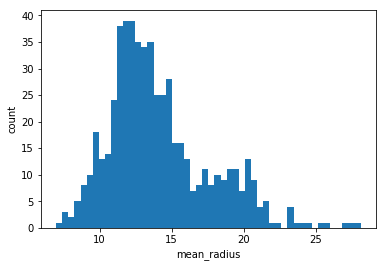

In [472]:
X = wdbc["mean_radius"]

plt.hist(X, bins=50)
plt.xlabel("mean_radius")
_ = plt.ylabel("count")

We can reject the hypothesis that the data is Normally distributed straight away. The radius feature reported here is non-negative; the univariate Normal distribution, on the other hand, has support in $\mathbb{R}$. The feature distribution could perhaps be reasonably-well approximated by a Normal distribution but a better choice, in light of the apparent positive skewness in the data, would be the Gamma or LogNormal distribution. However, even a skewed distribution with semi-infinite support is probably not a good choice here. To me, it looks like the data can be better described by a mixture model. 

I will formulate my answer as a Bayesian model selection problem. I will use MCMC to compare various probabilistic models: Normal, Gamma, a mixture of Normals and a mixture of Gammas.

### Mixture model with latent variables

Data $\{X_i\}$ in the mixture model is generated by a process that consists of $k$ Normal distributions:

$$ X_{i} \sim \mathcal{N} \left( f(\alpha_i), g(\alpha_i) \right) $$

Here, $f$ and $g$ are deterministic functions of a latent random variable $\alpha_i \in \{1, 2,\dots,k\}$, which determines which of the $k$ distributions a sample was generated by. We use

$$ \alpha_{i} \sim \text{Categorical}(\boldsymbol{p}) $$

where $\boldsymbol{p} = (p_1, p_2,\dots, p_k)$ is the random vector of probabilities that correspond to sample generation by the $i_{th}$ distribution. We can think of these as the weights of the $k$ components. We will use a Dirichlet prior for the mixture weights, which is also the conjugate prior of the Categorical distribution:

$$ \boldsymbol{p} \sim \text{Dirichlet}(\boldsymbol{1}) $$

I used a vector of $1$s for the parameter of the Dirichlet to keep this prior uninformative.

We will infer the $\alpha_i$, as well as $\boldsymbol{p}$, in our simulations. 

The deterministic functions set the mean and standard deviation for each sample based on each $\alpha_i$:

$$ 
f(\alpha_i) = \begin{cases} 
      \mu_0, & \alpha_i = 0 \\
      \mu_1, & \alpha_i = 1 \\
      \dots
   \end{cases}
$$

and 

$$ 
g(\alpha_i) = \begin{cases} 
      \sigma_0, & \alpha_i = 0 \\
      \sigma_1, & \alpha_i = 1 \\
      \dots
   \end{cases}
$$

We choose non-informative priors for the k Normal means:

$$
\mu_0, \mu_1, \dots, \mu_k \sim \mathcal{N}(\hat x, \hat\sigma(x))
$$

where the mean and standard deviation are empirically estimated from the sample. Similarly, for the k Normal standard deviations we choose:

$$
\sigma_0, \sigma_1, \dots \sigma_k \sim \text{Uniform}(0, 100)
$$

[Gelman 2006](https://projecteuclid.org/euclid.ba/1340371048) recommends using uniform or half-Cauchy priors for the variance parameter of a normal distribution, so we'll go with the simpler choice.

We will infer $\boldsymbol{\mu} = (\mu_1, \mu_2, \dots \mu_k)$ and $\boldsymbol{\sigma} = (\sigma_1, \sigma_2, \dots, \sigma_k)$, along with the $\alpha_i$ and $\boldsymbol{p}$, through our MCMC simulations.

The data looks bimodal, so let's start with a mixture model with two Normals.

In [307]:
n_clusters = 2
n_data = X.shape[0]

n_samples = int(1e5)
n_chains = 1

mixture_model_2 = pm.Model()
with mixture_model_2:
    
    p = pm.Dirichlet('p', a=np.ones(n_clusters), shape=n_clusters)
    alpha = pm.Categorical("alpha", p=p, shape=n_data)
    
    # Define prior distributions for cluster parameters:
    
    # Use sample means and standard deviations.
    prior_means = np.array([np.mean(X)] * n_clusters)
    prior_std_devs = np.array([np.std(X)] * n_clusters)
    
    # The Normal means and standard deviations to infer.
    means = pm.Normal("means", mu=prior_means, sd=prior_std_devs, shape=n_clusters)
    std_devs = pm.Uniform("std_devs", 0, 10, shape=n_clusters)
    
    # The final generative process is Normal.
    obs_data = pm.Normal("observed", mu=means[alpha], sd=std_devs[alpha], observed=X)
    
with mixture_model_2:
    step_alpha = pm.ElemwiseCategorical(vars=[alpha], values=np.arange(n_clusters))
    step_parameters = pm.Metropolis(vars=[p, means, std_devs])
    mixture_trace_2 = pm.sample(n_samples, step=[step_alpha, step_parameters], chains=n_chains)

/home/christos/Documents/Bay/env/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
Sequential sampling (1 chains in 1 job)
CompoundStep
>ElemwiseCategorical: [alpha]
>CompoundStep
>>Metropolis: [std_devs]
>>Metropolis: [means]
>>Metropolis: [p]
100%|██████████| 100500/100500 [14:11<00:00, 118.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Check the chains for convergence.

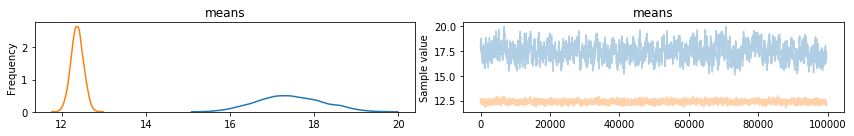

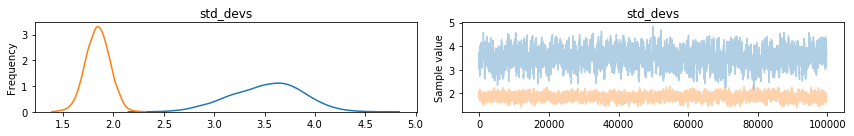

In [308]:
burnin = n_data // 2
pm.plots.traceplot(trace=mixture_trace_2[burnin:], varnames=["means"])
_ = pm.plots.traceplot(trace=mixture_trace_2[burnin:], varnames=["std_devs"])

Samples for the second (blue) standard deviation parameter have considerable variance. I suspect this may be due to the structure of our model rather than problems with convergence.

Plot the posterior distributions.

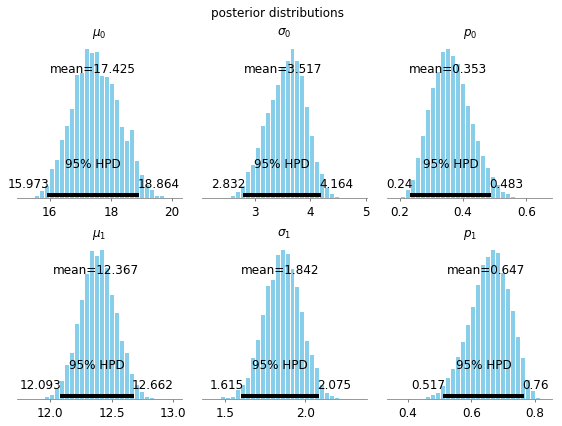

In [309]:
fig, ax = plt.subplots(2, 3, figsize=(8,6))

pm.plots.plot_posterior(trace=mixture_trace_2["means"][burnin:,0], ax=ax[0][0])
ax[0][0].set_title("$\mu_0$")

pm.plots.plot_posterior(trace=mixture_trace_2["means"][burnin:,1], ax=ax[1][0])
ax[1][0].set_title("$\mu_1$")

pm.plots.plot_posterior(trace=mixture_trace_2["std_devs"][burnin:,0], ax=ax[0][1])
ax[0][1].set_title("$\sigma_0$")

pm.plots.plot_posterior(trace=mixture_trace_2["std_devs"][burnin:,1], ax=ax[1][1])
ax[1][1].set_title("$\sigma_1$")

pm.plots.plot_posterior(trace=mixture_trace_2["p"][burnin:,0], ax=ax[0][2])
ax[0][2].set_title("$p_0$")

pm.plots.plot_posterior(trace=mixture_trace_2["p"][burnin:,1], ax=ax[1][2])
ax[1][2].set_title("$p_1$")

fig.suptitle("posterior distributions")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

We can see that, in spite of the sampling chains starting from the same initial positions, our inference uncovered two non-overlapping distributions for the means of the two consituent Normals.

Get a sense of how well this model fits the data by overlaying two Normals using the mean of the posteriors.

In [310]:
mean_posterior_p = np.mean(mixture_trace_2["p"][burnin:], axis=0)
p = mean_posterior_p

mean_posterior_means = np.mean(mixture_trace_2["means"][burnin:], axis=0)
m = mean_posterior_means

mean_posterior_std_devs = np.mean(mixture_trace_2["std_devs"][burnin:], axis=0)
s = mean_posterior_std_devs

x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X), 100)

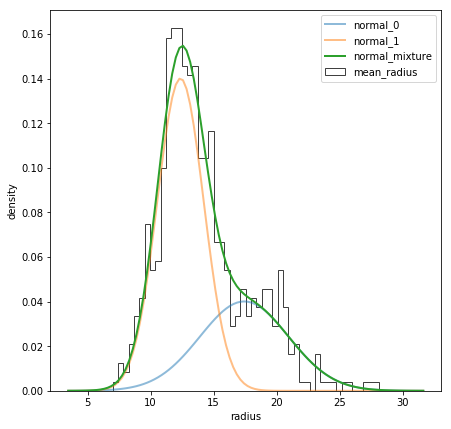

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.hist(X, bins=50, histtype="step", color="k", alpha=0.75, density=True)
for i in range(2):
    ax.plot(x_range, p[i] * stats.norm.pdf(x_range, loc=m[i], scale=s[i]),
            alpha=0.5,
            label='normal_%d' % i,
            linewidth=2)
    
ax.plot(x_range,
         p[0] * stats.norm.pdf(x_range, loc=m[0], scale=s[0]) +
         p[1] * stats.norm.pdf(x_range, loc=m[1], scale=s[1]),
         label='normal_mixture', linewidth=2)
    
plt.legend()
ax.set_xlabel("radius")
_ = ax.set_ylabel("density")

Not bad, but it looks like the inferred parameters for the cluster on the right are impaired by the right-tail outliers in the sample.

We can also see this from the sampling traces and posteriors of the standard deviation parameter, which itself has a large variance. This suggests that Normal components might not be appropriate for this data.

### Gaussian model

In [312]:
n_samples = int(1e5)
n_chains = 1

normal_model = pm.Model()

with normal_model:
    
    # The Normal means and standard deviations to infer.
    mean = pm.Normal("mean", mu=np.mean(X), sd=np.std(X))
    std_dev = pm.Uniform("std_dev", 0, 10)
    
    # The final generative process is Normal.
    obs_data = pm.Normal("observed", mu=mean, sd=std_dev, observed=X)
    
with normal_model:
    step_parameters = pm.Metropolis(vars=[mean, std_dev])
    normal_trace = pm.sample(n_samples, step=[step_parameters], chains=n_chains)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [std_dev]
>Metropolis: [mean]
100%|██████████| 100500/100500 [00:20<00:00, 4916.52it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling chains:

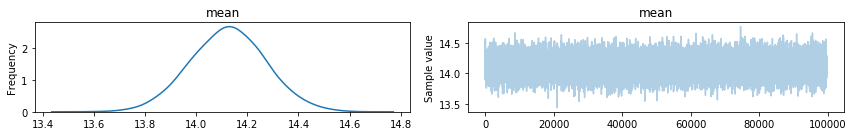

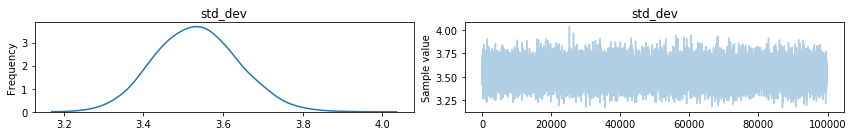

In [313]:
burnin = n_data // 2
pm.plots.traceplot(trace=normal_trace[burnin:], varnames=["mean"])
_ = pm.plots.traceplot(trace=normal_trace[burnin:], varnames=["std_dev"])

Posteriors:

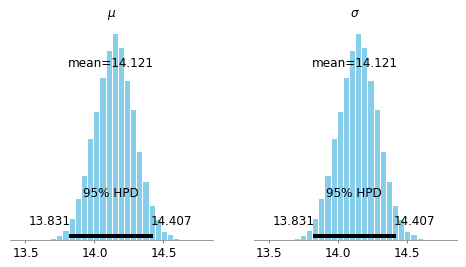

In [314]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
pm.plots.plot_posterior(trace=normal_trace["mean"][burnin:], ax=ax[0])
ax[0].set_title("$\mu$")
pm.plots.plot_posterior(trace=normal_trace["mean"][burnin:], ax=ax[1])
_ = ax[1].set_title("$\sigma$")

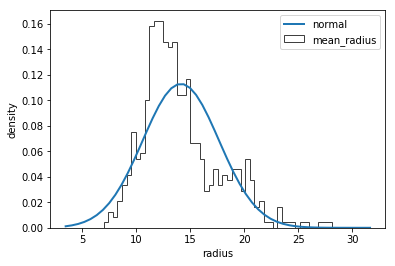

In [316]:
mean_posterior_mean = np.mean(normal_trace["mean"][burnin:], axis=0)
mean_posterior_std_dev = np.mean(normal_trace["std_dev"][burnin:], axis=0)
x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X))

fig, ax = plt.subplots(1, 1)
ax.hist(X, bins=50, histtype="step", color="k", alpha=0.75, density=True)
ax.plot(x_range, stats.norm.pdf(x_range, loc=mean_posterior_mean,
                                         scale=mean_posterior_std_dev), 
        linewidth=2, label="normal")
ax.set_xlabel("radius")
ax.set_ylabel("density")
_ = plt.legend()

### Gamma model

In [317]:
n_samples = int(1e5)
n_chains = 1

gamma_model = pm.Model()

with gamma_model:
    
    # The Normal means and standard deviations to infer.
    mean = pm.Normal("mean", mu=np.mean(X), sd=np.std(X))
    std_dev = pm.Uniform("std_dev", 0, 10)
    
    # The final generative process is Normal.
    obs_data = pm.Gamma("observed", mu=mean, sd=std_dev, observed=X)
    
with gamma_model:
    step_parameters = pm.Metropolis(vars=[mean, std_dev])
    gamma_trace = pm.sample(n_samples, step=[step_parameters], chains=n_chains)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [std_dev]
>Metropolis: [mean]
100%|██████████| 100500/100500 [00:21<00:00, 4604.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


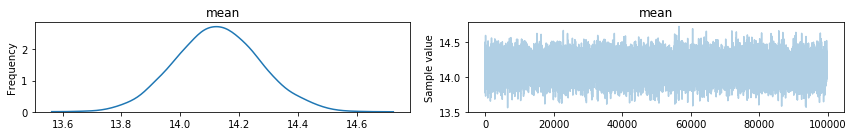

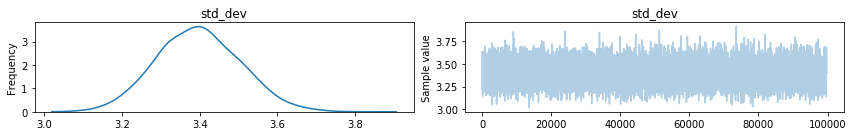

In [318]:
burnin = n_data // 2
pm.plots.traceplot(trace=gamma_trace[burnin:], varnames=["mean"])
_ = pm.plots.traceplot(trace=gamma_trace[burnin:], varnames=["std_dev"])

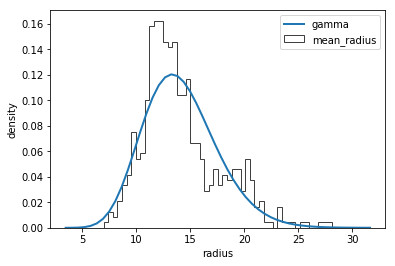

In [319]:
mean_posterior_mean = np.mean(gamma_trace["mean"][burnin:], axis=0)
m = mean_posterior_mean
mean_posterior_std_dev = np.mean(gamma_trace["std_dev"][burnin:], axis=0)
s = mean_posterior_std_dev
x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X))

fig, ax = plt.subplots(1, 1)
ax.hist(X, bins=50, histtype="step", color="k", alpha=0.75, density=True)
ax.plot(x_range, stats.gamma.pdf(x_range, a=(m**2)/(s**2), scale=(s**2)/m),
        linewidth=2, label="gamma")
ax.set_xlabel("radius")
ax.set_ylabel("density")
_ = plt.legend()

Looks better than the Gaussian model. We quantify this intuition in the next section.

### Model comparison and conslusions

 In comparing our probabilistic models, we need to keep in mind that the Gaussian mixture model can certainly overfit, so we want to be fully Bayesian and account for its larger number of fitting parameters. Ideally, we would like to calculate Bayes factors. Our sampling procedure, however, omits the marginal likelihood to only calculate proportional posteriors. Therefore, the posterior samples from our models are not immediately directly comparable.

The [Widely-applicable Information Criterion (WAIC)](http://www.jmlr.org/papers/volume14/watanabe13a/watanabe13a.pdf) is an approximation method for model comparison. Briefly, the WAIC is calculated from the computed log pointwise posterior predictive density, which is adjusted for the effective number of parameters to correct for overfitting.

[Note: you will see a fourth model in the exposition below. This is a mixture of two Gamma distributions that I simulated out of curiosity (see Appendix).]

In [326]:
normal_model.name = "normal"
gamma_model.name = "gamma"
mixture_model_2.name = "mixture_normal"
mixture_model_gamma_2.name = "mixture_gamma"

burnin = n_data // 2

waic = pm.compare({normal_model: normal_trace[burnin:],
                   gamma_model: gamma_trace[burnin:], 
                   mixture_model_2: mixture_trace_2[burnin:],
                   mixture_model_gamma_2: mixture_gamma_trace_2[burnin:]},
                  ic='WAIC')

In [327]:
waic  # show comparisons

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
mixture_normal,2732.73,121.19,0,1,30.39,0,1
mixture_gamma,2791,132.1,58.27,0,31.62,8.84,1
gamma,2978.5,2.07,245.77,0,37.23,22.61,0
normal,3045.96,2.36,313.24,0,40.34,26.71,0


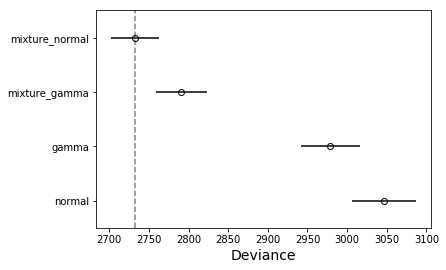

In [328]:
fig, ax = plt.subplots(1, 1)
pm.compareplot(waic, insample_dev=False, ax=ax, dse=False)

In the plot above, circles are mean WAIC scores and error bars are standard errors. The broken line shows score of the best-performing model. Lower WAIC scores are better.

The mixture models outperform the Normal and Gamma models (lowest WAIC scores), and the two mixture models perform similarly to each other. Of the two single-distribution models, the Gamma model fits our data better than the Normal. 

We can therefore draw the following conclusions:

1. We reject the hypothesis that the mean(radius) feature is Normally distributed -- even as an approximation -- in favor of the Gamma distribution. Remember that we can reject the Normal distribution off-hand because of its support in $\mathbb{R}$.
2. The data ought to be described as a mixture model of at least two (see Appendix B) distributions, be they Normal or Gamma, rather than any single distribution .

These conclusions are quantified and supported through the difference in model WAIC scores.

### Appendix A: Mixture of Gamma distributions

I also wanted to see how a mixture model with Gamma, rather than Normal, distributions would perform. The parametrization is the same as that of the Normal mixture.

In [321]:
n_samples = int(1e5)
n_chains = 1

n_clusters = 2
n_data = X.shape[0]

mixture_model_gamma_2 = pm.Model()
with mixture_model_gamma_2:
    
    p = pm.Dirichlet('p', a=np.ones(n_clusters), shape=n_clusters)
    alpha = pm.Categorical("alpha", p=p, shape=n_data)
    
    # Define prior distributions for cluster parameters:
    
    # Use sample means and standard deviations.
    prior_means = np.array([np.mean(X)] * n_clusters)
    prior_std_devs = np.array([np.std(X)] * n_clusters)
    
    # The Normal means and standard deviations to infer.
    means = pm.Normal("means", mu=prior_means, sd=prior_std_devs, shape=n_clusters)
    std_devs = pm.Uniform("std_devs", 0, 10, shape=n_clusters)
    
    # The final generative process is Gamma.
    obs_data = pm.Gamma("observed", mu=means[alpha], sd=std_devs[alpha], observed=X)
    
with mixture_model_gamma_2:
    step_alpha = pm.ElemwiseCategorical(vars=[alpha], values=np.arange(n_clusters))
    step_parameters = pm.Metropolis(vars=[p, means, std_devs])
    mixture_gamma_trace_2 = pm.sample(n_samples, step=[step_alpha, step_parameters], chains=n_chains)

/home/christos/Documents/Bay/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
Sequential sampling (1 chains in 1 job)
CompoundStep
>ElemwiseCategorical: [alpha]
>CompoundStep
>>Metropolis: [std_devs]
>>Metropolis: [means]
>>Metropolis: [p]
100%|██████████| 100500/100500 [14:27<00:00, 115.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


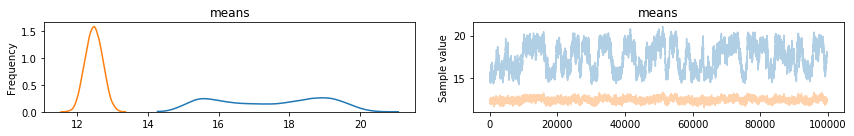

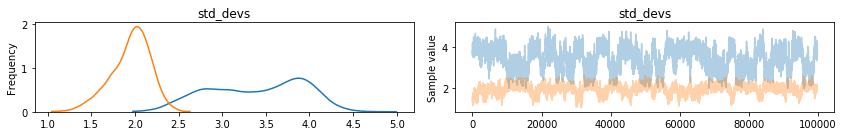

In [322]:
burnin = n_data // 2
pm.plots.traceplot(trace=mixture_gamma_trace_2[burnin:], varnames=["means"])
_ = pm.plots.traceplot(trace=mixture_gamma_trace_2[burnin:], varnames=["std_devs"])

These traces look pretty bad, as far as convergence goes. But they do hint at something interesting: that three components might be better for our data than two. We investigate this in Appendix B.

In [323]:
mean_posterior_p = np.mean(mixture_gamma_trace_2["p"][burnin:], axis=0)
p = mean_posterior_p

mean_posterior_means = np.mean(mixture_gamma_trace_2["means"][burnin:], axis=0)
m = mean_posterior_means

mean_posterior_std_devs = np.mean(mixture_gamma_trace_2["std_devs"][burnin:], axis=0)
s = mean_posterior_std_devs

x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X), 100)

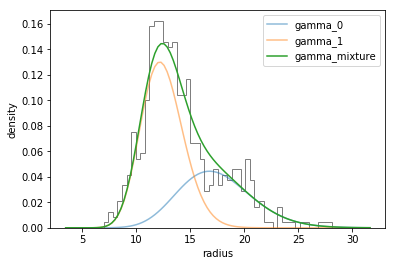

In [324]:
plt.hist(X, bins=50, histtype="step", color="k", alpha=0.5, density=True)
for i in range(2):
    plt.plot(x_range, 
             p[i] * stats.gamma.pdf(x_range, a=(m[i]**2)/(s[i]**2), scale=(s[i]**2)/m[i]),
             alpha=0.5,
             label='gamma_%d' % i)
    
plt.plot(x_range, p[0] * stats.gamma.pdf(x_range, a=(m[0]**2)/(s[0]**2), scale=(s[0]**2)/m[0]) +
                  p[1] * stats.gamma.pdf(x_range, a=(m[1]**2)/(s[1]**2), scale=(s[1]**2)/m[1]),
         label='gamma_mixture')
    
plt.legend()
plt.xlabel("radius")
_ = plt.ylabel("density")

### Appendix B: Mixture models with k=3

How do mixture models with k=3 perform compared to one with k=2? I simulated both mixtures of Normals and mixtures of Gammas.

Gamma k=3 first.

In [455]:
import pymc3.distributions.transforms as tr

n_clusters = 3
n_data = X.shape[0]
n_samples = int(1e4)

mixture_model_gamma_3 = pm.Model()
with mixture_model_gamma_3:
    
    p = pm.Dirichlet('p', a=np.ones(n_clusters), shape=n_clusters)
    alpha = pm.Categorical("alpha", p=p, shape=n_data)
    
    # Define prior distributions for cluster parameters:
    
    # Use sample means and standard deviations.
    prior_means = np.array([np.mean(X)] * n_clusters)
    prior_std_devs = np.array([np.std(X)] * n_clusters)
    
    # The Normal means and standard deviations to infer.
    means = pm.Normal("means", mu=prior_means, sd=prior_std_devs, shape=n_clusters)
    std_devs = pm.Uniform("std_devs", 0, 10, shape=n_clusters)
    
    # Set log-likelikehoods to zero when our initial mean ordering is violated.
    # This reduces the dreaded label switching problem.
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))    
    
    # The final generative process is Gamma.
    obs_data = pm.Gamma("observed", mu=means[alpha], sd=std_devs[alpha], observed=X)
    
with mixture_model_gamma_3:
    step_alpha = pm.CategoricalGibbsMetropolis(vars=[alpha])#, values=np.arange(n_clusters))
    step_parameters = pm.Metropolis(vars=[p, means, std_devs])
    mixture_gamma_trace_3 = pm.sample(n_samples, step=[step_alpha, step_parameters], chains=n_chains)

Sequential sampling (1 chains in 1 job)
CompoundStep
>CategoricalGibbsMetropolis: [alpha]
>CompoundStep
>>Metropolis: [std_devs]
>>Metropolis: [means]
>>Metropolis: [p]
100%|██████████| 10500/10500 [14:57<00:00, 11.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4cb0bb1be0>,
      dtype=object)

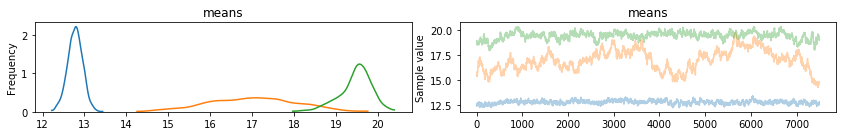

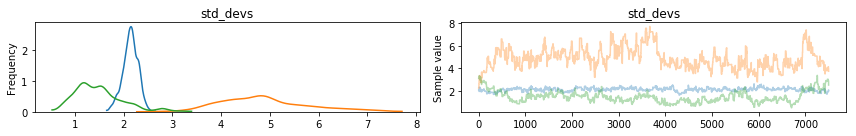

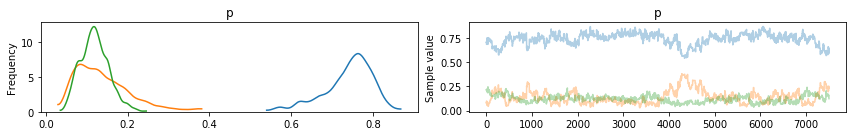

In [457]:
burnin = n_samples // 4
pm.plots.traceplot(trace=mixture_gamma_trace_3[burnin:], varnames=["means"], combined=True)
pm.plots.traceplot(trace=mixture_gamma_trace_3[burnin:], varnames=["std_devs"], combined=True)
pm.plots.traceplot(trace=mixture_gamma_trace_3[burnin:], varnames=["p"], combined=True)

In [458]:
mean_posterior_p = np.mean(mixture_gamma_trace_3["p"][burnin:], axis=0)
p = mean_posterior_p

mean_posterior_means = np.mean(mixture_gamma_trace_3["means"][burnin:], axis=0)
m = mean_posterior_means

mean_posterior_std_devs = np.mean(mixture_gamma_trace_3["std_devs"][burnin:], axis=0)
s = mean_posterior_std_devs

x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X), 100)

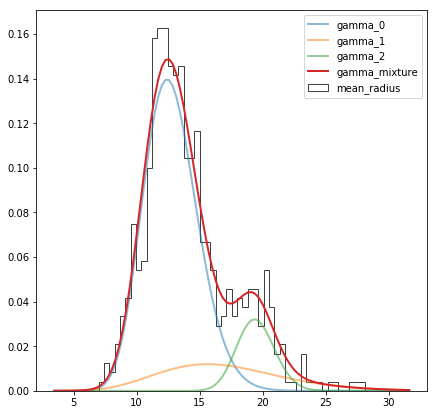

In [459]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.hist(X, bins=50, histtype="step", color="k", alpha=0.75, density=True)
for i in range(3):
    ax.plot(x_range, p[i] * stats.gamma.pdf(x_range, a=(m[i]**2)/(s[i]**2), scale=(s[i]**2)/m[i]),
            alpha=0.5,
            label='gamma_%d' % i,
            linewidth=2)
    
ax.plot(x_range, p[0] * stats.gamma.pdf(x_range, a=(m[0]**2)/(s[0]**2), scale=(s[0]**2)/m[0]) +
                 p[1] * stats.gamma.pdf(x_range, a=(m[1]**2)/(s[1]**2), scale=(s[1]**2)/m[1]) +
                 p[2] * stats.gamma.pdf(x_range, a=(m[2]**2)/(s[2]**2), scale=(s[2]**2)/m[2]),
         label='gamma_mixture', linewidth=2)

plt.legend()

Normal k=3 next.

In [465]:
n_clusters = 3
n_data = X.shape[0]

n_samples = int(1e4)
n_chains = 1

mixture_model_3 = pm.Model()
with mixture_model_3:
    
    p = pm.Dirichlet('p', a=np.ones(n_clusters), shape=n_clusters)
    alpha = pm.Categorical("alpha", p=p, shape=n_data)
    
    # Define prior distributions for cluster parameters:
    
    # Use sample means and standard deviations.
    prior_means = np.array([np.mean(X)] * n_clusters)
    prior_std_devs = np.array([np.std(X)] * n_clusters)
    
    # The Normal means and standard deviations to infer.
    means = pm.Normal("means", mu=prior_means, sd=prior_std_devs, shape=n_clusters)
    std_devs = pm.Uniform("std_devs", 0, 10, shape=n_clusters)
    
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))        
    
    # The final generative process is Normal.
    obs_data = pm.Normal("observed", mu=means[alpha], sd=std_devs[alpha], observed=X)
    
with mixture_model_3:
    step_alpha = pm.ElemwiseCategorical(vars=[alpha], values=np.arange(n_clusters))
    step_parameters = pm.Metropolis(vars=[p, means, std_devs])
    mixture_trace_3 = pm.sample(n_samples, step=[step_alpha, step_parameters], chains=n_chains)

/home/christos/Documents/Bay/env/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
Sequential sampling (1 chains in 1 job)
CompoundStep
>ElemwiseCategorical: [alpha]
>CompoundStep
>>Metropolis: [std_devs]
>>Metropolis: [means]
>>Metropolis: [p]
100%|██████████| 10500/10500 [01:29<00:00, 116.97it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4caf0ec908>,
      dtype=object)

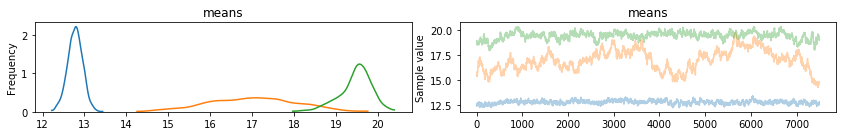

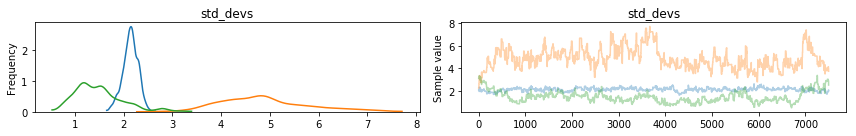

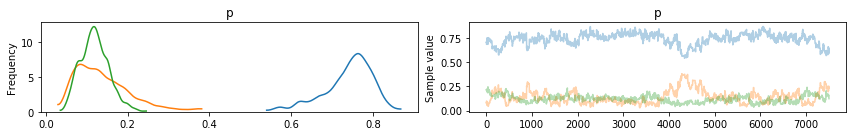

In [466]:
burnin = n_samples // 4
pm.plots.traceplot(trace=mixture_gamma_trace_3[burnin:], varnames=["means"], combined=True)
pm.plots.traceplot(trace=mixture_gamma_trace_3[burnin:], varnames=["std_devs"], combined=True)
pm.plots.traceplot(trace=mixture_gamma_trace_3[burnin:], varnames=["p"], combined=True)

In [467]:
mean_posterior_p = np.mean(mixture_gamma_trace_3["p"][burnin:], axis=0)
p = mean_posterior_p

mean_posterior_means = np.mean(mixture_gamma_trace_3["means"][burnin:], axis=0)
m = mean_posterior_means

mean_posterior_std_devs = np.mean(mixture_gamma_trace_3["std_devs"][burnin:], axis=0)
s = mean_posterior_std_devs

x_range = np.linspace(np.min(X) - np.std(X), np.max(X) + np.std(X), 100)

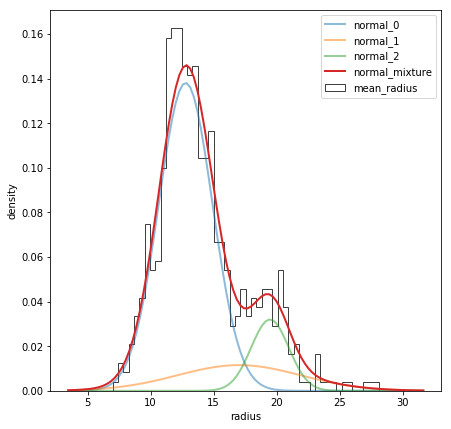

In [468]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.hist(X, bins=50, histtype="step", color="k", alpha=0.75, density=True)
for i in range(3):
    ax.plot(x_range, p[i] * stats.norm.pdf(x_range, loc=m[i], scale=s[i]),
            alpha=0.5,
            label='normal_%d' % i,
            linewidth=2)
    
ax.plot(x_range,
         p[0] * stats.norm.pdf(x_range, loc=m[0], scale=s[0]) +
         p[1] * stats.norm.pdf(x_range, loc=m[1], scale=s[1]) +
         p[2] * stats.norm.pdf(x_range, loc=m[2], scale=s[2]),
         label='normal_mixture', linewidth=2)
    
plt.legend()
ax.set_xlabel("radius")
_ = ax.set_ylabel("density")

In [469]:
normal_model.name = "normal"
gamma_model.name = "gamma"
mixture_model_2.name = "mixture_normal_2"
mixture_model_3.name = "mixture_normal_3"
mixture_model_gamma_2.name = "mixture_gamma_2"
mixture_model_gamma_3.name = "mixture_gamma_3"

waic = pm.compare({normal_model: normal_trace[len(normal_trace)//2:],
                   gamma_model: gamma_trace[len(gamma_trace)//2:], 
                   mixture_model_2: mixture_trace_2[len(mixture_trace_2)//2:],
                   mixture_model_3: mixture_trace_3[len(mixture_trace_3)//4:],
                   mixture_model_gamma_2: mixture_gamma_trace_2[len(mixture_gamma_trace_2)//2:],
                   mixture_model_gamma_3: mixture_gamma_trace_3[len(mixture_gamma_trace_3)//4:]},
                   ic='WAIC')

In [470]:
waic

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
mixture_normal_3,2707.92,150.05,0,0.92,29.88,0,1
mixture_normal_2,2732.27,121.15,24.36,0,30.38,1.24,1
mixture_gamma_3,2732.49,146.62,24.58,0.08,32.24,10.93,1
mixture_gamma_2,2854.76,100.04,146.84,0,33.39,13,1
gamma,2978.52,2.08,270.6,0,37.28,23.03,0
normal,3046.03,2.4,338.11,0,40.33,26.96,0


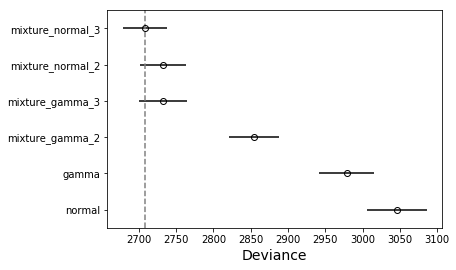

In [471]:
fig, ax = plt.subplots(1, 1)
pm.compareplot(waic, insample_dev=False, ax=ax, dse=False)

There is no evidence to support a model with more than two clusters. While it seems that both the Normal and Gamma mixture models fit the data better, the WAIC scores suggest that they are likely to be overfitting.

[Technical note: Gaussian mixture models have *much* nicer convergence properties!]